In [ ]:
!pip install "gym>=0.21.0"
!pip install tf-agents[reverb]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [ ]:
from tf_agents.specs import array_spec

In [ ]:
import os
import time
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/beerql

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/beerql


In [ ]:
from agent import SupplyChain
from data import *
import numpy as np

In [ ]:
class BeerGamePyEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=255, name='action')
    
    intmax, intmin = np.iinfo(np.int32).max, np.iinfo(np.int32).min
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(4,), 
        dtype=np.int32, 
        name='observation', 
        minimum=[intmin]*4, 
        maximum=[intmax]*4
        )

    self._state = (12,12,12,12)
    self._episode_ended = False
    self._cumulative_reward = 0
    self.sc = SupplyChain(data[MAIN])

  def custom_init(self, data):
      self.sc = SupplyChain(data)

      # initial state values for all levels in supply chain is 12
      # current state 
      self._state = (12,12,12,12)
      self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    # restore to initial values
    self.sc.reset()

    self._state = (12,12,12,12)
    self._episode_ended = False
    self._cumulative_reward = 0
    return ts.restart(np.array(self._state, dtype=np.int32))#check if sq.braces needed

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()
    
    obs, reward, done, info = self.sc.rl_env_step(action) 
    #.d print(">",action,reward,obs)
    self._episode_ended = done
    self._state = obs
    self._cumulative_reward += reward

    if self._episode_ended:
      return ts.termination(
          np.array(self._state, dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array(self._state, dtype=np.int32), reward, discount=1.0)

In [ ]:
# validate environment
environment = BeerGamePyEnv()
environment.custom_init(data=data[MAIN])
utils.validate_py_environment(environment, episodes=3)

In [ ]:
# run 1 complete episode + 1 time step to confirm episode ended
action = np.array(0, dtype=np.int32)

environment = BeerGamePyEnv()
environment.custom_init(data=data[MAIN])
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for i in range(36):
  time_step = environment.step(i)
  print(time_step)
  cumulative_reward += time_step.reward

print('Final Reward = ', cumulative_reward)

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [ ]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"} 

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [ ]:
from tf_agents.environments import TimeLimit
env = BeerGamePyEnv()
env = TimeLimit(env,35)

In [ ]:
train_py_env = BeerGamePyEnv()
eval_py_env = BeerGamePyEnv()
#env.custom_init(data=data[MAIN])
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
#environment.custom_init(data=data[MAIN])
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [ ]:
compute_avg_return(eval_env, random_policy, 5)

-3786.8

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [ ]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([9, 4, 2, 9], dtype=int32),
  'reward': array(-70., dtype=float32),
  'step_type': array(1, dtype=int32)}), ())

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

In [ ]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 9672.4345703125
step = 400: loss = 7076.91064453125
step = 600: loss = 11758.83203125
step = 800: loss = 6258.6376953125
step = 1000: loss = 14121.3544921875
step = 1000: Average Return = -4066.0
step = 1200: loss = 10972.0302734375
step = 1400: loss = 11301.880859375
step = 1600: loss = 6991.470703125
step = 1800: loss = 10904.01953125
step = 2000: loss = 6708.1279296875
step = 2000: Average Return = -4343.0
step = 2200: loss = 10410.154296875
step = 2400: loss = 7923.23828125
step = 2600: loss = 7875.2666015625
step = 2800: loss = 8610.298828125
step = 3000: loss = 11612.482421875
step = 3000: Average Return = -4605.0
step = 3200: loss = 13729.83984375
step = 3400: loss = 13815.98046875
step = 3600: loss = 7986.37841796875
step = 3800: loss = 16335.3359375
step = 4000: loss = 14024.1328125
step = 4000: Average Return = -4613.0
step = 4200: loss = 20434.90625
step = 4400: loss = 10974.56640625
step = 4600: loss = 17019.177734375
step = 4800: loss = 6963.328125
step 

Text(0.5, 0, 'Iterations')

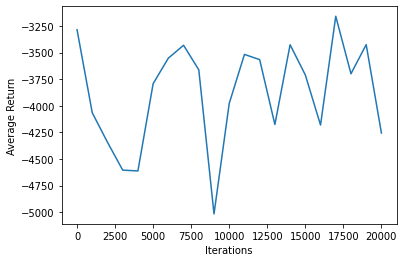

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')